In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

class MobileNetV2():
    def __init__(self,dataset=None, classNames=None):
        # self.model was formerly base_model
        BATCH_SIZE = 32
        self.IMG_SIZE = (160, 160)
        
        if dataset:
            PATH = dataset
            self.train_dir = os.path.join(PATH, 'train')
            self.validation_dir = os.path.join(PATH, 'validation')
            self.train_dataset = tf.keras.utils.image_dataset_from_directory(self.train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=self.IMG_SIZE)
            self.validation_dataset = tf.keras.utils.image_dataset_from_directory(self.validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=self.IMG_SIZE)
            self.class_names = self.train_dataset.class_names
        
        else:

            _URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
            path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
            PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

            

            self.train_dir = os.path.join(PATH, 'train')
            self.validation_dir = os.path.join(PATH, 'validation')
            self.train_dataset = tf.keras.utils.image_dataset_from_directory(self.train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=self.IMG_SIZE)
            self.validation_dataset = tf.keras.utils.image_dataset_from_directory(self.validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=self.IMG_SIZE)

            AUTOTUNE = tf.data.AUTOTUNE
            self.class_names = self.train_dataset.class_names
            print(self.train_dataset)

        
        self.base_learning_rate = 0.0001

    
    def show_train(self):
        plt.figure(figsize=(10, 10))
        for images, labels in self.train_dataset.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(self.class_names[labels[i]])
                plt.axis("off")

    def get_batches(self):
        val_batches = tf.data.experimental.cardinality(self.validation_dataset)
        self.test_dataset = self.validation_dataset.take(val_batches // 5)
        self.validation_dataset = self.validation_dataset.skip(val_batches // 5)
        print('Number of validation batches: %d' % tf.data.experimental.cardinality(self.validation_dataset))
        print('Number of test batches: %d' % tf.data.experimental.cardinality(self.test_dataset))
   
    def augment(self):
        self.data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal'),tf.keras.layers.RandomRotation(0.2),])
        for image, _ in self.train_dataset.take(1):
            plt.figure(figsize=(10, 10))
            first_image = image[0]
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                augmented_image = self.data_augmentation(tf.expand_dims(first_image, 0))
                plt.imshow(augmented_image[0] / 255)
                plt.axis('off')

    def pre_process(self):
        preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
        rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

        # Create the base model from the pre-trained model MobileNet V2
        IMG_SHAPE = self.IMG_SIZE + (3,)
        self.base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

        image_batch, label_batch = next(iter(self.train_dataset))
        feature_batch = self.base_model(image_batch)
        print(feature_batch.shape)

        self.base_model.trainable = False

        # Let's take a look at the base model architecture
        self.base_model.summary()

        global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
        feature_batch_average = global_average_layer(feature_batch)
        print(feature_batch_average.shape)

        prediction_layer = tf.keras.layers.Dense(1)
        prediction_batch = prediction_layer(feature_batch_average)
        print(prediction_batch.shape)


        inputs = tf.keras.Input(shape=(160, 160, 3))
        x = self.data_augmentation(inputs)
        x = preprocess_input(x)
        x = self.base_model(x, training=False)
        x = global_average_layer(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        outputs = prediction_layer(x)
        self.model = tf.keras.Model(inputs, outputs)

        
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.base_learning_rate),
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'])

        self.model.summary()

        len(self.model.trainable_variables)

        self.initial_epochs = 10

        loss0, accuracy0 = self.model.evaluate(self.validation_dataset)

        print("initial loss: {:.2f}".format(loss0))
        print("initial accuracy: {:.2f}".format(accuracy0))

        self.history = self.model.fit(self.train_dataset,
                    epochs=self.initial_epochs,
                    validation_data=self.validation_dataset)
        
    def the_one_after(self):
        self.acc = self.history.history['accuracy']
        self.val_acc = self.history.history['val_accuracy']

        self.loss = self.history.history['loss']
        self.val_loss = self.history.history['val_loss']

        plt.figure(figsize=(8, 8))
        plt.subplot(2, 1, 1)
        plt.plot(self.acc, label='Training Accuracy')
        plt.plot(self.val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.ylabel('Accuracy')
        plt.ylim([min(plt.ylim()),1])
        plt.title('Training and Validation Accuracy')

        plt.subplot(2, 1, 2)
        plt.plot(self.loss, label='Training Loss')
        plt.plot(self.val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.ylabel('Cross Entropy')
        plt.ylim([0,1.0])
        plt.title('Training and Validation Loss')
        plt.xlabel('epoch')
        plt.show()

    def the_second(self):
        self.base_model.trainable = True

        # Let's take a look to see how many layers are in the base model
        print("Number of layers in the base model: ", len(self.base_model.layers))

        # Fine-tune from this layer onwards
        fine_tune_at = 100

        # Freeze all the layers before the `fine_tune_at` layer
        for layer in self.base_model.layers[:fine_tune_at]:
            layer.trainable = False


        self.model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    optimizer = tf.keras.optimizers.RMSprop(learning_rate=self.base_learning_rate/10),
                    metrics=['accuracy'])

        self.model.summary()

        len(self.model.trainable_variables)

        self.fine_tune_epochs = 10
        total_epochs =  self.initial_epochs + self.fine_tune_epochs

        self.history_fine = self.model.fit(self.train_dataset,
                                epochs=total_epochs,
                                initial_epoch=self.history.epoch[-1],
                                validation_data=self.validation_dataset)
        
    def third(self):
        self.acc += self.history_fine.history['accuracy']
        self.val_acc += self.history_fine.history['val_accuracy']

        self.loss += self.history_fine.history['loss']
        self.val_loss += self.history_fine.history['val_loss']

        plt.figure(figsize=(8, 8))
        plt.subplot(2, 1, 1)
        plt.plot(self.acc, label='Training Accuracy')
        plt.plot(self.val_acc, label='Validation Accuracy')
        plt.ylim([0.8, 1])
        plt.plot([self.initial_epochs-1,self.initial_epochs-1],
                plt.ylim(), label='Start Fine Tuning')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(2, 1, 2)
        plt.plot(self.loss, label='Training Loss')
        plt.plot(self.val_loss, label='Validation Loss')
        plt.ylim([0, 1.0])
        plt.plot([self.initial_epochs-1,self.initial_epochs-1],
                plt.ylim(), label='Start Fine Tuning')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.xlabel('epoch')
        plt.show()

        self.loss, accuracy = self.model.evaluate(self.test_dataset)
        print('Test accuracy :', accuracy)



    def fourth(self):
        # Retrieve a batch of images from the test set
        image_batch, label_batch = self.test_dataset.as_numpy_iterator().next()
        predictions = self.model.predict_on_batch(image_batch).flatten()

        # Apply a sigmoid since our model returns logits
        # issue seems to be here, 3 classes as opposed to to two with the cats and dogs example.
        # look for a multi-class example to compare against not sure how to get predictions but all Dermacentor Variabilis is wrong
        predictions = tf.nn.sigmoid(predictions)
        predictions = tf.where(predictions < 0.5, 0, 1)

        print('Predictions:\n', predictions.numpy())
        print('Labels:\n', label_batch)

        plt.figure(figsize=(10, 10))
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(image_batch[i].astype("uint8"))
            plt.title(self.class_names[predictions[i]])
            plt.axis("off")

    def save_model(self, path):
        self.model.save(path)
        return

In [2]:
from tensorflow import keras
def load_model(path):
    model = keras.models.load_model(path)
    return model



In [10]:
# TensorFlow and tf.keras
import tensorflow as tf

from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt


#img_path = './new_dataset/validation/Amblyomma americanum/83217545.jpg'
img_path = './new_dataset/validation/Dermacentor variabilis/7802483.jpg'

img = image.load_img(img_path, target_size=(160, 160))

img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis = 0)
img_preprocessed = preprocess_input(img_batch)




model = load_model('./models/SecondClass2')

predictions = np.argmax(model.predict(img_preprocessed), axis=-1)

print(predictions)
#print(decode_predictions(prediction, top=3))

1/1 [==============================] - 1s 602ms/step
[0]


In [9]:
predictions = np.argmax(model.predict(img_preprocessed), axis=-1)

print(predictions)

1/1 [==============================] - 0s 71ms/step
[0]


Found 2700 files belonging to 3 classes.
Found 1208 files belonging to 3 classes.
Number of validation batches: 31
Number of test batches: 7
(32, 5, 5, 1280)
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_5[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                    

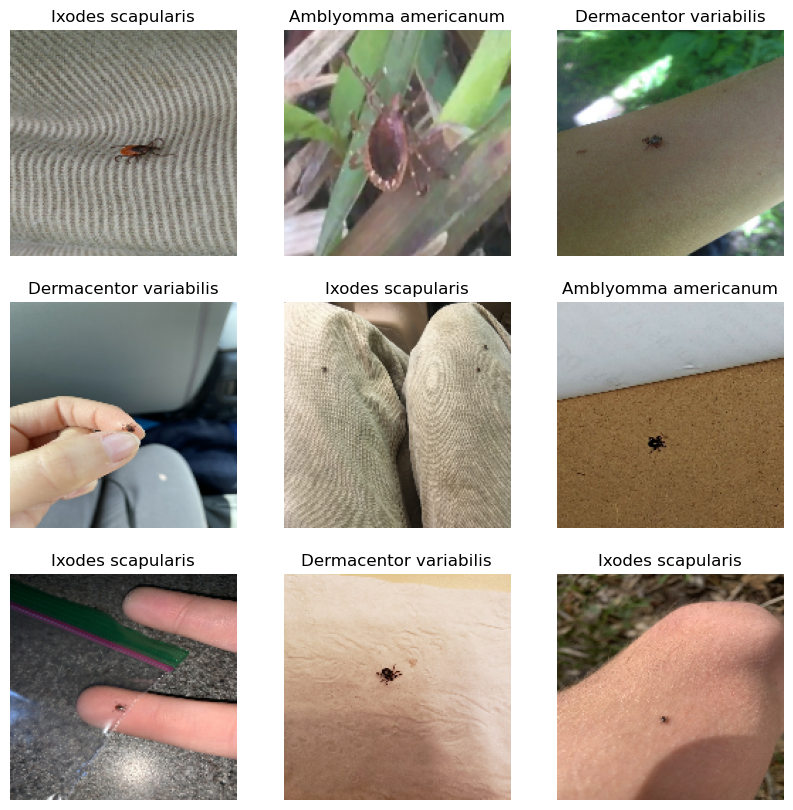

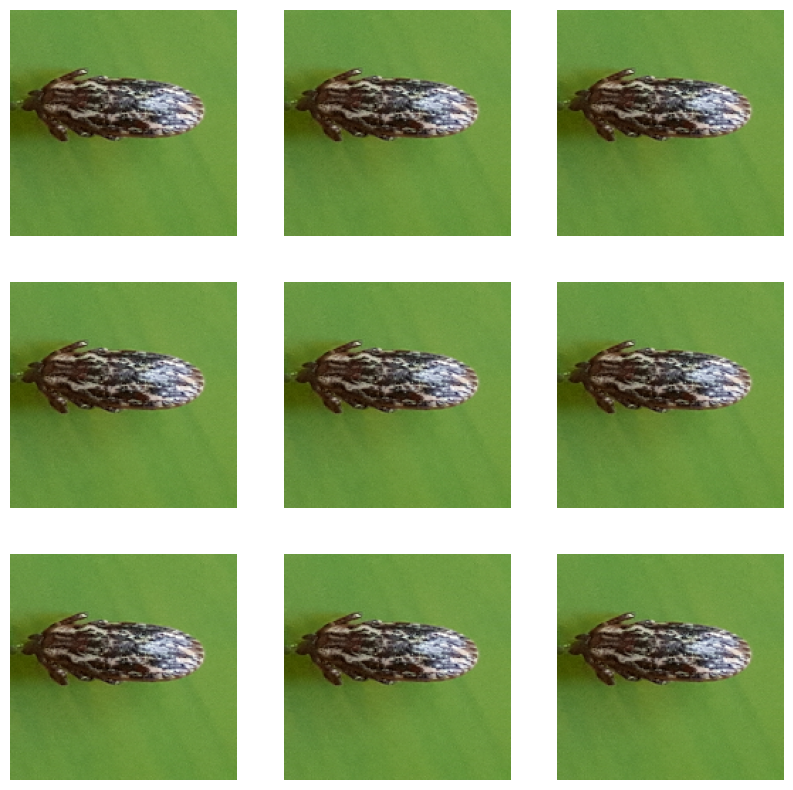

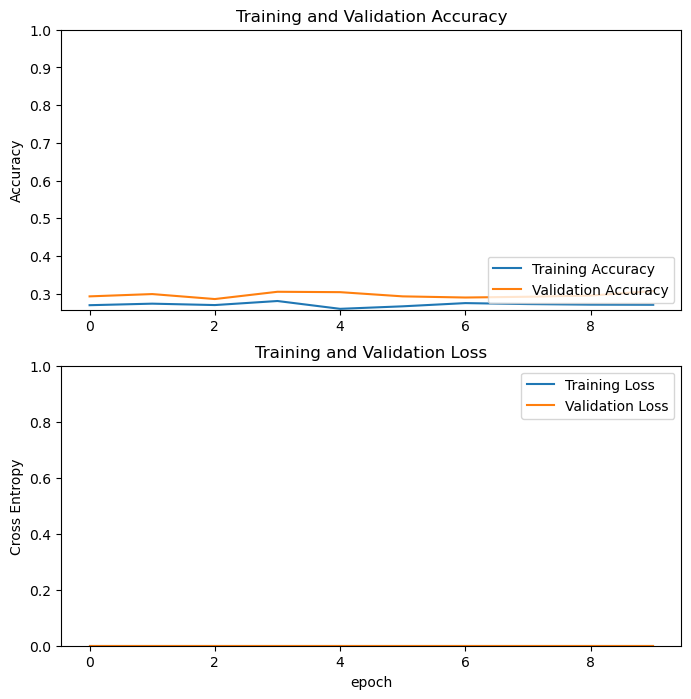

Number of layers in the base model:  154
Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_5[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None,

ValueError: in user code:

    File "c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\keras\engine\training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\keras\losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\keras\losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\keras\losses.py", line 1787, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\ShepDaddy\anaconda3\envs\ECE371H\lib\site-packages\keras\backend.py", line 5119, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None,) and (None, 5, 5, 1280) are incompatible


In [7]:


myClass = MobileNetV2(dataset = './new_dataset', classNames = ["Dermacentor variabilis", "Ixodes scapularis" ,"Ambloyomma americanum"])

 
myClass.show_train()
# visualization will fail with current code, intending to set up as 
myClass.get_batches()

myClass.augment()

myClass.pre_process()

myClass.the_one_after()

myClass.the_second()

myClass.third()

myClass.fourth()

myClass.save_model('./models/SecondClass2')


In [13]:
myClass.save_model('./models/SecondClass')

INFO:tensorflow:Assets written to: ./models/FirstBadClass.sav\assets


INFO:tensorflow:Assets written to: ./models/FirstBadClass.sav\assets


In [14]:
load_model('./models/FirstBadClass.sav')

In [18]:
import pandas as pd

df = pd.read_csv('TableS1.csv', index_col='id')
print(df)

my_id = 20636

df.loc[my_id]['scientific_name']

            observed_on  month    user_id           user_login  \
id                                                               
20636.0        6/7/2011      6        1.0                kueda   
41227.0       12/5/2011     12     2179.0              charlie   
1182988.0      5/5/2013      5    69447.0    kellyfuerstenberg   
3187779.0     5/14/2016      5    53860.0  berkshirenaturalist   
3187812.0     5/14/2016      5    53860.0  berkshirenaturalist   
...                 ...    ...        ...                  ...   
52095043.0     7/5/2020      7  1819353.0            wsweet321   
104157584.0   5/26/2021      5  5282916.0       gary_iacobucci   
63505328.0   10/25/2020     10  3779065.0       stevewolfinger   
105513091.0    5/5/2013      5   606705.0         jacobgorneau   
105579986.0   5/30/2013      5   606705.0         jacobgorneau   

                          created_at quality_grade      license  \
id                                                                
20636.0

'Dermacentor variabilis'

In [27]:
df.loc[0]['scientific_name']

'Dermacentor variabilis'

In [3]:
import requests
from bs4 import BeautifulSoup
from lxml import etree
import numpy as np
import csv
import os
import time

xpaths = '/html/head/meta[12]'
url = 'https://www.inaturalist.org/observations/{identity:s}'

for i in range(173, len(df.index)):
    try:
    
        test = str(int(df.loc[i].at['id']))
        #print(test)
        

        pathy = 'dataset/'+test+'.jpg'

        if not os.path.exists(pathy): 
            #print(url.format(identity = test))
            headers = {"User-Agent":"Mozilla/5.0"}
            requested = requests.get(url.format(identity = test), headers = headers)
            soup = BeautifulSoup(requested.content, 'lxml')
            dom = etree.HTML(str(soup)) #. beautiful soup stuff


            aws_url = dom.xpath(xpaths)[0].attrib['content']

            img_data = requests.get(aws_url).content
            with open(pathy, 'wb') as handler:
                handler.write(img_data)

            time.sleep(1)


    except:
        print('failed index [{index_1:d}], failed id [{id_1:s}]'.format(index_1 = i, id_1 = test))
    

failed index [302], failed id [28024481]
failed index [348], failed id [100080461]
failed index [1316], failed id [90701495]
failed index [1805], failed id [69678266]
failed index [2891], failed id [79820657]
failed index [3297], failed id [103320154]
failed index [3393], failed id [27114407]


In [44]:
test = str(int(df.loc[175].at['id']))
#print(test)



#print(url.format(identity = test))
headers = {"User-Agent":"Mozilla/5.0"}
requested = requests.get(url.format(identity = test), headers = headers)
soup = BeautifulSoup(requested.content, 'lxml')
dom = etree.HTML(str(soup)) #. beautiful soup stuff


aws_url = dom.xpath(xpaths)[0].attrib['content']


img_data = requests.get(aws_url).content
with open('dataset/'+test+'.jpg', 'wb') as handler:
    handler.write(img_data)

In [21]:
soup.find_all('div')

[<div id="bodywrapper">
 <div class="bootstrap" id="header">
 <div class="navtabs" id="logonav">
 <a class="logolink innertab" href="/" title="iNaturalist">
 <img alt="iNaturalist" src="https://static.inaturalist.org/sites/1-logo.svg?1573071870"/>
 </a>
 </div>
 <div class="search navtabs form-group" id="headersearch">
 <div class="searchwrapper">
 <input class="form-control" placeholder="Search" tabindex="-1" type="text"/>
 </div>
 <button class="btn btn-default btn-inat btn-focus show-btn">
 <i class="fa fa-search"></i>
 </button>
 <button class="btn btn-link hide-btn">
 <i class="fa fa-times-circle"></i>
 </button>
 </div>
 <ul class="navtabs" id="mainnav">
 <li class="navtab active">
 <a href="/observations">Explore</a>
 </li>
 <li class="navtab communitytab menutab">
 <div class="dropdown">
 <div aria-expanded="false" aria-haspopup="true" class="dropdown-toggle" data-toggle="dropdown" id="header-community-dropdown-toggle">
 <a href="/people">Community</a>
 <i class="fa fa-angle-do

In [22]:
soup

<!DOCTYPE html>
<html dir="ltr" lang="en" xml:lang="en" xmlns="http://www.w3.org/1999/xhtml" xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#">
<head>
<title>American Dog Tick from Bluff Point State Park, CT, USA on June 07, 2011 at 04:34 PM by Ken-ichi Ueda
 ·  iNaturalist </title>
<meta content="en" http-equiv="Content-Language"/>
<link href="https://static.inaturalist.org/sites/1-favicon.png?1573071870" rel="shortcut icon" type="image/x-icon"/>
<meta content="width=980" name="viewport"/>
<link href="/assets/font-awesome-2f50fecc97d9114f8339e0a5f68490c63e2b9c94374eeee6c7685856b2d4669d.css" media="screen" rel="stylesheet"/>
<link href="/assets/application_bundle-c633d05907f14ed34900ab23ebd7de27ffed273e0c3ff47c533b9e77504dd6e6.css" media="screen" rel="stylesheet"/>
<link href="https://static.inaturalist.org/sites/1-stylesheet.css?1573579729" media="screen" rel="stylesheet"/>
<!--[if lte IE 7]>
  <link rel="stylesheet" media="screen" href="/assets/ie-86931db2aba1

In [16]:
%conda install bs4


Solving environment: ...working... done

## Package Plan ##

  environment location: c:\Users\ShepDaddy\anaconda3\envs\ECE371H

  added / updated specs:
    - bs4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bs4-4.11.1                 |       hd3eb1b0_0           5 KB
    ------------------------------------------------------------
                                           Total:           5 KB

The following NEW packages will be INSTALLED:

  bs4                pkgs/main/noarch::bs4-4.11.1-hd3eb1b0_0 




bs4-4.11.1           | 5 KB      |            |   0% 
bs4-4.11.1           | 5 KB      | ########## | 100% 
bs4-4.11.1           | 5 KB      | ########## | 100% 
                                                     


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done

Note: you may need to restart the ker

In [17]:
%conda install lxml

Solving environment: ...working... done

## Package Plan ##

  environment location: c:\Users\ShepDaddy\anaconda3\envs\ECE371H

  added / updated specs:
    - lxml


The following NEW packages will be INSTALLED:

  lxml               pkgs/main/win-64::lxml-4.9.1-py310h1985fb9_0 





Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [3]:
from PIL import Image
import numpy as np
import sys
import os
import csv
# default format can be changed as needed
def createFileList(myDir, format='.jpg'):
    fileList = []
    #print(myDir)
    labels = []
    names = []
    keywords = {"Ambloyomma americanum": "2", "Ixodes scapularis" : "1","Dermacentor variabilis": "0"} # keys and values to be changed as needed
    index = 0
    for root, dirs, files in os.walk(myDir, topdown=True):
        for name in files:
            if name.endswith(format):
                fullName = os.path.join(root, name)
                fileList.append(fullName)
            for keyword in keywords:
                if keyword in df.loc[index]['scientific_name']: # Need to parse df by file name, so v look up w/ file name and then pull the name
                    labels.append(keywords[keyword])
                    
                else:
                    #print(df.loc[index]['scientific_name'])
                    continue
            names.append(name)
            index += 1
    return fileList, labels, names


In [20]:
# load the original image
myFileList, labels, names  = createFileList('./dataset')
i = 0
for file in myFileList:
    print(file)
    img_file = Image.open(file)
    # img_file.show()
    # get original image parameters...
    width, height = img_file.size
    format = img_file.format
    mode = img_file.mode
    # Make image Greyscale
    img_grey = img_file.convert('RGB')
    #img_grey.save('result.png')
    #img_grey.show()
    # Save Greyscale values
    # value = np.asarray(img_grey.getdata(), dtype=np.int).reshape((height , width,))
    value = np.asarray(img_grey.getdata(), dtype=np.int).reshape((width, height, 3))
    value = value.flatten()
    print("labels: ", labels[i])
    #print("value:", ' '.join(value))

    #try:
    temp = ' '.join(map(str,value))
    newValue = [temp,labels[i]]
    
    i +=1
    
    #print(value)
    with open("NortheastTicks.csv", 'a') as f:
        writer = csv.writer(f)
        writer.writerow(newValue)
    
    #except:
     #   print("broke")
     #   break


./dataset\100069300.jpg
labels:  0


C:\Users\ShepDaddy\AppData\Local\Temp\ipykernel_18196\547355821.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  value = np.asarray(img_grey.getdata(), dtype=np.int).reshape((width, height, 3))


./dataset\100115623.jpg
labels:  1
./dataset\100124106.jpg
labels:  0
./dataset\100165702.jpg
labels:  0
./dataset\100165703.jpg
labels:  0
./dataset\100165704.jpg
labels:  0
./dataset\100165707.jpg
labels:  0
./dataset\100165708.jpg
labels:  1
./dataset\100187986.jpg
labels:  1
./dataset\100228367.jpg
labels:  1
./dataset\10024464.jpg
labels:  1
./dataset\100286233.jpg
labels:  1
./dataset\100323443.jpg
labels:  0
./dataset\100399249.jpg
labels:  1
./dataset\100399615.jpg
labels:  1
./dataset\100419622.jpg
labels:  0
./dataset\100458592.jpg
labels:  0
./dataset\10050521.jpg
labels:  0
./dataset\100519700.jpg
labels:  0
./dataset\100521739.jpg
labels:  1
./dataset\100586880.jpg
labels:  1
./dataset\10060422.jpg
labels:  0
./dataset\100652347.jpg
labels:  1
./dataset\100661758.jpg
labels:  1
./dataset\100701482.jpg
labels:  1
./dataset\100717421.jpg
labels:  1
./dataset\10073573.jpg
labels:  0
./dataset\100801193.jpg
labels:  1
./dataset\100849956.jpg
labels:  1
./dataset\100867461.jpg


IndexError: list index out of range

In [40]:
next(os.walk('/dataset', topdown=True))


StopIteration: 

In [18]:
df.head

<bound method NDFrame.head of             observed_on  month    user_id           user_login  \
id                                                               
20636.0        6/7/2011      6        1.0                kueda   
41227.0       12/5/2011     12     2179.0              charlie   
1182988.0      5/5/2013      5    69447.0    kellyfuerstenberg   
3187779.0     5/14/2016      5    53860.0  berkshirenaturalist   
3187812.0     5/14/2016      5    53860.0  berkshirenaturalist   
...                 ...    ...        ...                  ...   
52095043.0     7/5/2020      7  1819353.0            wsweet321   
104157584.0   5/26/2021      5  5282916.0       gary_iacobucci   
63505328.0   10/25/2020     10  3779065.0       stevewolfinger   
105513091.0    5/5/2013      5   606705.0         jacobgorneau   
105579986.0   5/30/2013      5   606705.0         jacobgorneau   

                          created_at quality_grade      license  \
id                                          

In [23]:
df.set_index("id", inplace = True)
df.loc[20083.0]

KeyError: "None of ['id'] are in the columns"